In [39]:
# import relevant libraries
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency,f_oneway

#### merge urls to recipe dataframe

In [40]:
# recipes dataframes
# there is a mismatch in df3_urls and df3_recipes 2430 vs 1022
df1 = pd.read_csv('../ScrapeData/csv_recipes/recipe_df1.csv')
df2 = pd.read_csv('../ScrapeData/csv_recipes/recipe_df2.csv')
df3 = pd.read_csv('../ScrapeData/csv_recipes/recipe_df3.csv')
df4 = pd.read_csv('../ScrapeData/csv_recipes/recipe_df4.csv')
df5 = pd.read_csv('../ScrapeData/csv_recipes/recipe_df5.csv')
df6 = pd.read_csv('../ScrapeData/csv_recipes/recipe_df6.csv')
df7 = pd.read_csv('../ScrapeData/csv_recipes/recipe_df7.csv')
df8 = pd.read_csv('../ScrapeData/csv_recipes/recipe_df8.csv')

In [41]:
# concat the dataframes
df_recipes = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8])
df_recipes = df_recipes.drop(['Unnamed: 0','id'], axis=1) #drop columns not required

In [42]:
df_recipes=df_recipes.reset_index(drop='index')

In [43]:
# url dataframes
df1_url = pd.read_csv('../ScrapeData/csv_urls/urls_df1.csv')
df2_url = pd.read_csv('../ScrapeData/csv_urls/urls_df2.csv')
df3_url = pd.read_csv('../ScrapeData/csv_urls/urls_df3.csv')
df3_url = df3_url.iloc[:1022,:]
df4_url = pd.read_csv('../ScrapeData/csv_urls/urls_df4.csv')
df5_url = pd.read_csv('../ScrapeData/csv_urls/urls_df5.csv')
df6_url = pd.read_csv('../ScrapeData/csv_urls/urls_df6.csv')

In [44]:
# concat the dataframes url and recipes
df_url = pd.concat([df1_url,df2_url, df3_url, df4_url,df5_url,df6_url])
df_url = df_url.drop(['Unnamed: 0'], axis=1) #drop columns not required

In [45]:
df_url = df_url.reset_index(drop='index')

In [46]:
# merge df_url and df_recipes
df = pd.concat([df_url,df_recipes],axis=1)

### preprocessing the dataframe

In [47]:
df['makeitagainscore'] = pd.to_numeric(df['makeitagainscore'].str.replace('%', ''))

In [48]:
# drop rows if there are null value records
df.dropna(axis=0, how='any', inplace=True,subset=['bestrating','ingredients',\
                            'makeitagainscore','preparation','rating','reviews','tags','title'])

In [49]:
# refine the ingredients column
df["ingredients_refined"] = ""
for index, row in df.iterrows():
    ingredients_items = ast.literal_eval(row["ingredients"])
    df.set_value(index,'ingredients_refined',ingredients_items)

In [50]:
# refine the tags column
df["tags_refined"] = ""
for index, row in df.iterrows():
    tag_items = ast.literal_eval(row["tags"])
    df.set_value(index,'tags_refined',tag_items)

#### Create a class for ratings

In [51]:
df['rating'].value_counts()

3.5    6452
3.0    2955
4.0    1432
2.5     560
2.0      71
1.5      18
1.0       5
0.0       1
Name: rating, dtype: int64

In [52]:
def classify_rating(rating):
    if rating == 4:
        return 'exceptional'
    
    elif rating == 3.5:
        return 'good'
    
    elif rating == 3:
        return 'average'
    
    else:
        return 'negative'

In [53]:
df['rating_class'] = df['rating'].apply(classify_rating)

In [54]:
#class distribution
df['rating_class'].value_counts()

good           6452
average        2955
exceptional    1432
negative        655
Name: rating_class, dtype: int64

In [55]:
len(df)

11494

In [56]:
df.head(2)

,batch,urls,bestrating,imagesrc,ingredients,makeitagainscore,preparation,rating,reviews,tags,title,ingredients_refined,tags_refined,rating_class
0,0-249,https://www.epicurious.com/recipes/food/views/...,4.0,https://assets.epicurious.com/photos/56df1d8cb...,"['2 cups whole-wheat flour', '2 cups all-purpo...",90.0,Put oven rack in middle position and preheat o...,3.5,50.0,"['Irish', 'Bread', 'Bake', 'Vegetarian', 'Quic...",Irish Brown Bread,"[2 cups whole-wheat flour, 2 cups all-purpose ...","[Irish, Bread, Bake, Vegetarian, Quick & Easy,...",good
1,0-249,https://www.epicurious.com/recipes/food/views/...,4.0,https://assets.epicurious.com/photos/5a78b5919...,"['1 Tbsp. crushed red pepper flakes', '1 Tbsp....",91.0,"Coarsely grind red pepper flakes, peppercorns,...",3.0,11.0,"['Pepper', 'Fennel', 'Pork', 'Garlic', 'White ...",Slow-Cooked Pork with Chickpeas,"[1 Tbsp. crushed red pepper flakes, 1 Tbsp. wh...","[Pepper, Fennel, Pork, Garlic, White Wine, Oni...",average


### EDA

#### Relationship between image availability and rating

In [57]:
df['imagesrc_class'] = np.where(df['imagesrc'].isnull(), 'no', 'yes')

In [58]:
# get propotion by rating class
chi_df = pd.crosstab(df['imagesrc_class'],df['rating_class'])

In [59]:
chi_df

rating_class,average,exceptional,good,negative
imagesrc_class,,,,
no,1796,443,3222,389
yes,1159,989,3230,266


In [60]:
# null hypothesis ("action is independent of group") 
a = chi_df.iloc[0].values
b = chi_df.iloc[1].values

In [61]:
chi2, pvalue, _, _ = chi2_contingency([a, b])

In [62]:
chi2

365.03050705861506

In [63]:
pvalue

8.2970187032911645e-79

In [64]:
df['imagesrc_class'] = np.where(df['imagesrc'].isnull(), 0, 1)

#### Relationship between nu of ingredients and rating

In [65]:
df["ingredients_count"] = np.nan

In [66]:
for index, row in df.iterrows():
    elements = len(row["ingredients_refined"])
    df.set_value(index, "ingredients_count", elements)

In [67]:
df.head(2)

,batch,urls,bestrating,imagesrc,ingredients,makeitagainscore,preparation,rating,reviews,tags,title,ingredients_refined,tags_refined,rating_class,imagesrc_class,ingredients_count
0,0-249,https://www.epicurious.com/recipes/food/views/...,4.0,https://assets.epicurious.com/photos/56df1d8cb...,"['2 cups whole-wheat flour', '2 cups all-purpo...",90.0,Put oven rack in middle position and preheat o...,3.5,50.0,"['Irish', 'Bread', 'Bake', 'Vegetarian', 'Quic...",Irish Brown Bread,"[2 cups whole-wheat flour, 2 cups all-purpose ...","[Irish, Bread, Bake, Vegetarian, Quick & Easy,...",good,1,9.0
1,0-249,https://www.epicurious.com/recipes/food/views/...,4.0,https://assets.epicurious.com/photos/5a78b5919...,"['1 Tbsp. crushed red pepper flakes', '1 Tbsp....",91.0,"Coarsely grind red pepper flakes, peppercorns,...",3.0,11.0,"['Pepper', 'Fennel', 'Pork', 'Garlic', 'White ...",Slow-Cooked Pork with Chickpeas,"[1 Tbsp. crushed red pepper flakes, 1 Tbsp. wh...","[Pepper, Fennel, Pork, Garlic, White Wine, Oni...",average,1,14.0


In [68]:
# The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean
good = df[df['rating_class']=='good']['ingredients_count'].values
average = df[df['rating_class']=='average']['ingredients_count'].values
exceptional = df[df['rating_class']=='exceptional']['ingredients_count'].values
negative  = df[df['rating_class']=='negative']['ingredients_count'].values

In [69]:
f_oneway(good, average, exceptional, negative)

F_onewayResult(statistic=31.304527864418787, pvalue=3.8100567945250719e-20)

#### Relationship between nu of tags and rating

In [70]:
df["tags_count"] = np.nan

In [71]:
for index, row in df.iterrows():
    elements = len(row["tags_refined"])
    df.set_value(index, "tags_count", elements)

In [72]:
df.head(2)

,batch,urls,bestrating,imagesrc,ingredients,makeitagainscore,preparation,rating,reviews,tags,title,ingredients_refined,tags_refined,rating_class,imagesrc_class,ingredients_count,tags_count
0,0-249,https://www.epicurious.com/recipes/food/views/...,4.0,https://assets.epicurious.com/photos/56df1d8cb...,"['2 cups whole-wheat flour', '2 cups all-purpo...",90.0,Put oven rack in middle position and preheat o...,3.5,50.0,"['Irish', 'Bread', 'Bake', 'Vegetarian', 'Quic...",Irish Brown Bread,"[2 cups whole-wheat flour, 2 cups all-purpose ...","[Irish, Bread, Bake, Vegetarian, Quick & Easy,...",good,1,9.0,8.0
1,0-249,https://www.epicurious.com/recipes/food/views/...,4.0,https://assets.epicurious.com/photos/5a78b5919...,"['1 Tbsp. crushed red pepper flakes', '1 Tbsp....",91.0,"Coarsely grind red pepper flakes, peppercorns,...",3.0,11.0,"['Pepper', 'Fennel', 'Pork', 'Garlic', 'White ...",Slow-Cooked Pork with Chickpeas,"[1 Tbsp. crushed red pepper flakes, 1 Tbsp. wh...","[Pepper, Fennel, Pork, Garlic, White Wine, Oni...",average,1,14.0,12.0


In [73]:
# The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean
good = df[df['rating_class']=='good']['tags_count'].values
average = df[df['rating_class']=='average']['tags_count'].values
exceptional = df[df['rating_class']=='exceptional']['tags_count'].values
negative  = df[df['rating_class']=='negative']['tags_count'].values

In [74]:
f_oneway(good, average, exceptional, negative)

F_onewayResult(statistic=11.709595604400846, pvalue=1.1736181793116911e-07)

#### Relationship between makeitagainscore  and rating

In [75]:
df.head(2)

,batch,urls,bestrating,imagesrc,ingredients,makeitagainscore,preparation,rating,reviews,tags,title,ingredients_refined,tags_refined,rating_class,imagesrc_class,ingredients_count,tags_count
0,0-249,https://www.epicurious.com/recipes/food/views/...,4.0,https://assets.epicurious.com/photos/56df1d8cb...,"['2 cups whole-wheat flour', '2 cups all-purpo...",90.0,Put oven rack in middle position and preheat o...,3.5,50.0,"['Irish', 'Bread', 'Bake', 'Vegetarian', 'Quic...",Irish Brown Bread,"[2 cups whole-wheat flour, 2 cups all-purpose ...","[Irish, Bread, Bake, Vegetarian, Quick & Easy,...",good,1,9.0,8.0
1,0-249,https://www.epicurious.com/recipes/food/views/...,4.0,https://assets.epicurious.com/photos/5a78b5919...,"['1 Tbsp. crushed red pepper flakes', '1 Tbsp....",91.0,"Coarsely grind red pepper flakes, peppercorns,...",3.0,11.0,"['Pepper', 'Fennel', 'Pork', 'Garlic', 'White ...",Slow-Cooked Pork with Chickpeas,"[1 Tbsp. crushed red pepper flakes, 1 Tbsp. wh...","[Pepper, Fennel, Pork, Garlic, White Wine, Oni...",average,1,14.0,12.0


In [76]:
df.groupby(['rating_class']).agg({'makeitagainscore':np.mean})

,makeitagainscore
rating_class,
average,81.161083
exceptional,94.356145
good,89.667080
negative,64.444275


#### Relationship between preparation length and rating

In [77]:
df['preparation_length'] = df['preparation'].str.len()

In [78]:
df.head(2)

,batch,urls,bestrating,imagesrc,ingredients,makeitagainscore,preparation,rating,reviews,tags,title,ingredients_refined,tags_refined,rating_class,imagesrc_class,ingredients_count,tags_count,preparation_length
0,0-249,https://www.epicurious.com/recipes/food/views/...,4.0,https://assets.epicurious.com/photos/56df1d8cb...,"['2 cups whole-wheat flour', '2 cups all-purpo...",90.0,Put oven rack in middle position and preheat o...,3.5,50.0,"['Irish', 'Bread', 'Bake', 'Vegetarian', 'Quic...",Irish Brown Bread,"[2 cups whole-wheat flour, 2 cups all-purpose ...","[Irish, Bread, Bake, Vegetarian, Quick & Easy,...",good,1,9.0,8.0,829
1,0-249,https://www.epicurious.com/recipes/food/views/...,4.0,https://assets.epicurious.com/photos/5a78b5919...,"['1 Tbsp. crushed red pepper flakes', '1 Tbsp....",91.0,"Coarsely grind red pepper flakes, peppercorns,...",3.0,11.0,"['Pepper', 'Fennel', 'Pork', 'Garlic', 'White ...",Slow-Cooked Pork with Chickpeas,"[1 Tbsp. crushed red pepper flakes, 1 Tbsp. wh...","[Pepper, Fennel, Pork, Garlic, White Wine, Oni...",average,1,14.0,12.0,1506


In [79]:
# The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean
good = df[df['rating_class']=='good']['preparation_length'].values
average = df[df['rating_class']=='average']['preparation_length'].values
exceptional = df[df['rating_class']=='exceptional']['preparation_length'].values
negative  = df[df['rating_class']=='negative']['preparation_length'].values

In [80]:
f_oneway(good, average, exceptional, negative)

F_onewayResult(statistic=37.039236235565006, pvalue=8.1968865487923914e-24)

#### Relationship between title length and rating

In [81]:
df['title_length'] = df['title'].str.len()

In [82]:
df.head(2)

,batch,urls,bestrating,imagesrc,ingredients,makeitagainscore,preparation,rating,reviews,tags,title,ingredients_refined,tags_refined,rating_class,imagesrc_class,ingredients_count,tags_count,preparation_length,title_length
0,0-249,https://www.epicurious.com/recipes/food/views/...,4.0,https://assets.epicurious.com/photos/56df1d8cb...,"['2 cups whole-wheat flour', '2 cups all-purpo...",90.0,Put oven rack in middle position and preheat o...,3.5,50.0,"['Irish', 'Bread', 'Bake', 'Vegetarian', 'Quic...",Irish Brown Bread,"[2 cups whole-wheat flour, 2 cups all-purpose ...","[Irish, Bread, Bake, Vegetarian, Quick & Easy,...",good,1,9.0,8.0,829,18
1,0-249,https://www.epicurious.com/recipes/food/views/...,4.0,https://assets.epicurious.com/photos/5a78b5919...,"['1 Tbsp. crushed red pepper flakes', '1 Tbsp....",91.0,"Coarsely grind red pepper flakes, peppercorns,...",3.0,11.0,"['Pepper', 'Fennel', 'Pork', 'Garlic', 'White ...",Slow-Cooked Pork with Chickpeas,"[1 Tbsp. crushed red pepper flakes, 1 Tbsp. wh...","[Pepper, Fennel, Pork, Garlic, White Wine, Oni...",average,1,14.0,12.0,1506,32


In [83]:
# The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean
good = df[df['rating_class']=='good']['title_length'].values
average = df[df['rating_class']=='average']['title_length'].values
exceptional = df[df['rating_class']=='exceptional']['title_length'].values
negative  = df[df['rating_class']=='negative']['title_length'].values

In [84]:
f_oneway(good, average, exceptional, negative)

F_onewayResult(statistic=14.961675103744669, pvalue=1.0206358827905647e-09)

### Evaluate Some Algorithms

In [85]:
df.head(2)

,batch,urls,bestrating,imagesrc,ingredients,makeitagainscore,preparation,rating,reviews,tags,title,ingredients_refined,tags_refined,rating_class,imagesrc_class,ingredients_count,tags_count,preparation_length,title_length
0,0-249,https://www.epicurious.com/recipes/food/views/...,4.0,https://assets.epicurious.com/photos/56df1d8cb...,"['2 cups whole-wheat flour', '2 cups all-purpo...",90.0,Put oven rack in middle position and preheat o...,3.5,50.0,"['Irish', 'Bread', 'Bake', 'Vegetarian', 'Quic...",Irish Brown Bread,"[2 cups whole-wheat flour, 2 cups all-purpose ...","[Irish, Bread, Bake, Vegetarian, Quick & Easy,...",good,1,9.0,8.0,829,18
1,0-249,https://www.epicurious.com/recipes/food/views/...,4.0,https://assets.epicurious.com/photos/5a78b5919...,"['1 Tbsp. crushed red pepper flakes', '1 Tbsp....",91.0,"Coarsely grind red pepper flakes, peppercorns,...",3.0,11.0,"['Pepper', 'Fennel', 'Pork', 'Garlic', 'White ...",Slow-Cooked Pork with Chickpeas,"[1 Tbsp. crushed red pepper flakes, 1 Tbsp. wh...","[Pepper, Fennel, Pork, Garlic, White Wine, Oni...",average,1,14.0,12.0,1506,32


#### create a validation dataset

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11494 entries, 0 to 11523
Data columns (total 19 columns):
batch                  11494 non-null object
urls                   11494 non-null object
bestrating             11494 non-null float64
imagesrc               5644 non-null object
ingredients            11494 non-null object
makeitagainscore       11494 non-null float64
preparation            11494 non-null object
rating                 11494 non-null float64
reviews                11494 non-null float64
tags                   11494 non-null object
title                  11494 non-null object
ingredients_refined    11494 non-null object
tags_refined           11494 non-null object
rating_class           11494 non-null object
imagesrc_class         11494 non-null int64
ingredients_count      11494 non-null float64
tags_count             11494 non-null float64
preparation_length     11494 non-null int64
title_length           11494 non-null int64
dtypes: float64(6), int64(3), obje

In [114]:
df['rating_class'].value_counts()

good           6452
average        2955
exceptional    1432
negative        655
Name: rating_class, dtype: int64

In [115]:
validation_size = 0.20
seed = 7

In [116]:
X = df.values
y = df.values[:,13] # rating_class

In [117]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=validation_size, random_state=seed)

In [118]:
# NLP SPARSE
X_train_nlp = X_train[:,6]
X_validation_nlp = X_validation[:,6]
vect = TfidfVectorizer(stop_words='english')
tf_transformer = vect.fit(X_train_nlp)
# encode document
X_train_nlp = tf_transformer.transform(X_train_nlp)
X_validation_nlp = tf_transformer.transform(X_validation_nlp)

In [119]:
print(f"X_train_nlp:{X_train_nlp.shape}")
print(f"X_validation_nlp:{X_validation_nlp.shape}")

X_train_nlp:(9195, 7784)
X_validation_nlp:(2299, 7784)


In [120]:
# DENSE
X_train_dense = X_train[:,14:19] # imagesrc_class, ingredients_elements, tags_elements, preparation_length, title_length
X_validation_dense = X_validation[:,14:19]

In [121]:
print(f"X_train_dense:{X_train_dense.shape}")
print(f"X_validation_dense:{X_validation_dense.shape}")

X_train_dense:(9195, 5)
X_validation_dense:(2299, 5)


In [122]:
np.unique(y, return_counts=True)

(array(['average', 'exceptional', 'good', 'negative'], dtype=object),
 array([2955, 1432, 6452,  655]))

### PCA

In [123]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=500, n_iter=8, random_state=42)
svd.fit(X_train_nlp)

TruncatedSVD(algorithm='randomized', n_components=500, n_iter=8,
       random_state=42, tol=0.0)

In [124]:
print(svd.explained_variance_ratio_.sum())  

0.712912127927


In [125]:
X_train_nlp_pca = svd.transform(X_train_nlp)

In [126]:
X_train_nlp_pca.shape

(9195, 500)

In [127]:
X_validation_nlp_pca = svd.transform(X_validation_nlp)

In [128]:
X_validation_nlp_pca.shape

(2299, 500)

In [129]:
X_train = np.hstack((X_train_nlp_pca,X_train_dense)) 

In [130]:
X_validation = np.hstack((X_validation_nlp_pca,X_validation_dense)) 

In [131]:
X_train.shape

(9195, 505)

In [132]:
X_validation.shape

(2299, 505)

#### build models and cross validation

In [133]:
# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [134]:
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'

In [135]:
# kfold cross validation
from sklearn import model_selection

In [136]:
models = []
models.append(('LR',LogisticRegression()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('LDA',LinearDiscriminantAnalysis()))
# models.append(('NB',MultinomialNB()))
models.append(('SVM',SVC()))
models.append(('RF',RandomForestClassifier()))

In [137]:
#evaluate each model in turn 
results = []
names = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=10,random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.558893 (0.009662)
CART: 0.407612 (0.013262)
KNN: 0.448830 (0.016569)


/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


LDA: 0.529856 (0.011999)
SVM: 0.560416 (0.011943)
RF: 0.487769 (0.016629)


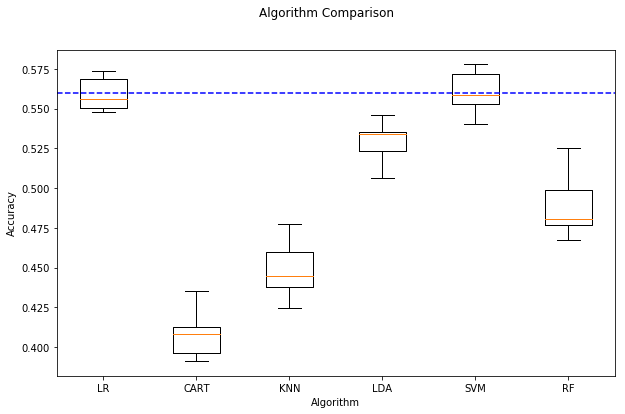

In [150]:
# Compare Algorithms
fig = plt.figure(figsize=(10,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(1,1,1)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_xlabel('Algorithm')
ax.set_ylabel('Accuracy')
plt.axhline(y=0.56, color='b', linestyle='--')
fig.savefig('algorithm.png')
plt.show()

#### make predictions

In [151]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

# Make predictions on validation dataset
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_validation)
print(accuracy_score(y_validation, predictions))
print(confusion_matrix(y_validation, predictions))
print(classification_report(y_validation, predictions))

0.56807307525
[[  69    1  514    0]
 [   2    6  284    0]
 [  63    4 1231    0]
 [  17    0  108    0]]
             precision    recall  f1-score   support

    average       0.46      0.12      0.19       584
exceptional       0.55      0.02      0.04       292
       good       0.58      0.95      0.72      1298
   negative       0.00      0.00      0.00       125

avg / total       0.51      0.57      0.46      2299



/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


If I understand correctly, you essentially have two forms of features for your models. (1) Text data that you have represented as a sparse bag of words and (2) more traditional dense features. If that is the case then there are 3 common approaches:

Perform dimensionality reduction (such as LSA via TruncatedSVD) on your sparse data to make it dense and combine the features into a single dense matrix to train your model(s).  

Add your few dense features to your sparse matrix using something like scipy's hstack into a single sparse matrix to train your model(s).  

Create a model using only your sparse text data and then combine its predictions (probabilities if it's classification) as a dense feature with your other dense features to create a model (ie: ensembling via stacking). If you go this route remember to only use CV predictions as features to train your model otherwise you'll likely overfit quite badly (you can make a quite class to do this all within a single Pipeline if desired).